In [1]:
import tensorflow as tf
import keras
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import os
from PIL import Image
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
def residual_block_gen(ch=32,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
    ])
    return model

def Upsample_block(x, ch=64, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st),padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def get_enhancer():
        
    input_lr=tf.keras.layers.Input(shape=(112,112,3))
    input_conv=tf.keras.layers.Conv2D(32,5,padding='same')(input_lr)
    input_conv=tf.keras.layers.LeakyReLU()(input_conv)
    SRRes=input_conv
    
    for x in range(2):
        
        res_output=residual_block_gen()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(32,5,padding='same')(SRRes)
        SRRes=tf.keras.layers.BatchNormalization()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,input_conv])
        
    SRRes = Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,5,activation='tanh',padding='same')(SRRes)

    return tf.keras.Model(input_lr,output_sr)

In [14]:
def Generator():
    model = keras.Sequential([

        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.UpSampling2D(2),
        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu'),
        keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')
        
    ])

    return model

In [34]:
model.layers[1]._name = 'super-resolution'
model.layers[2]._name = 'autoencoder-denoiser'
model.layers[0]._name = 'input'

In [60]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 112, 112, 3)]     0         
                                                                 
 model_14 (Functional)       (None, 224, 224, 3)       110643    
                                                                 
 sequential_26 (Sequential)  (None, 112, 112, 3)       191619    
                                                                 
Total params: 302,262
Trainable params: 302,134
Non-trainable params: 128
_________________________________________________________________


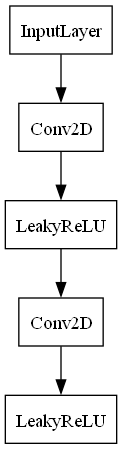

In [54]:
residual = residual_block_gen()
residual.build(input_shape=(None,112,112,3))
keras.utils.plot_model(residual,show_layer_names=False,to_file='./sequential.png')

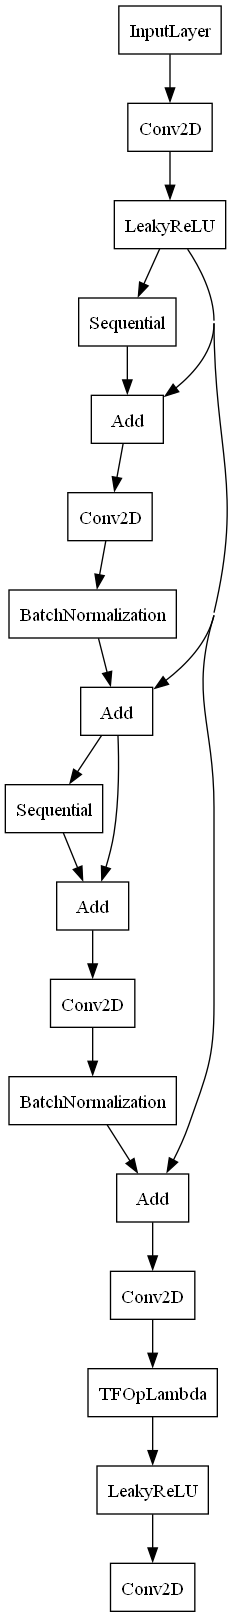

In [55]:
enhancer = get_enhancer()
enhancer.build(input_shape=(None,112,112,3))
keras.utils.plot_model(enhancer,show_layer_names=False,to_file='./enhancer_diagram.png')

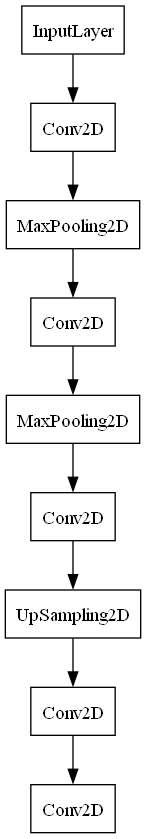

In [56]:
denoiser = Generator()
denoiser.build(input_shape=(None,112,112,3))
keras.utils.plot_model(denoiser,show_layer_names=False,to_file='./denoiser_diagram.png')

In [86]:
inputs = layers.Input(shape=(112,112,3))
hidden = get_enhancer()(inputs)
outputs =  Generator()(hidden)
model = keras.Model(inputs,outputs)

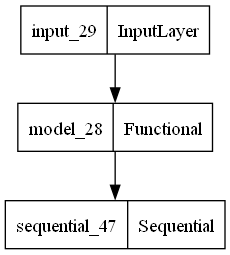

In [87]:
keras.utils.plot_model(model,show_layer_names=True,to_file='./model.png')